# VM Scheduling Optimization

## Overview

This notebook demonstrates a constraint programming approach to solving the Virtual Machine (VM) scheduling problem. The problem involves allocating processes (or virtual machines) to physical servers while respecting various constraints such as:

- Server resource limits (RAM, CPU, disk, bandwidth)
- Process requirements and affinities
- Location and redundancy policies
- Energy consumption and cost constraints

The solution uses Google OR-Tools' CP-SAT solver to find an optimal allocation that satisfies all constraints while optimizing for objectives like load balancing, energy efficiency, and cost.

## Available Constraints

The system supports a wide range of constraints that can be configured in the `constraints.yml` file. Here's a detailed explanation of each available constraint:

### Resource Utilization Constraints

| Constraint | Description | Format | Default |
|------------|-------------|--------|---------|
| `max-ram-usage-per-server` | Maximum percentage of RAM that can be used on each server. | Percentage (e.g., "75%") | 100% |
| `max-cpu-usage-per-server` | Maximum percentage of CPU cores that can be used on each server. | Percentage (e.g., "80%") | 100% |
| `max-disk-usage-per-server` | Maximum percentage of disk space that can be used on each server. | Percentage (e.g., "50%") | 100% |
| `max-network-bandwidth-per-server` | Maximum percentage of network bandwidth that can be used on each server. | Percentage (e.g., "80%") | 100% |

### Server Management Constraints

| Constraint | Description | Format | Default |
|------------|-------------|--------|---------|
| `servers-for-redundancy` | Number of servers to keep empty for redundancy/failover. | Integer (e.g., 0, 1, 2) | 0 |
| `max-processes-per-server` | Maximum number of processes that can be assigned to a single server. | Integer (e.g., 7) | No limit |
| `isolate-critical-processes` | If true, critical processes (marked with `critical: true`) will be isolated on servers with no non-critical processes. | Boolean (true/false) | false |

### Energy and Cost Constraints

| Constraint | Description | Format | Default |
|------------|-------------|--------|---------|
| `prioritize-green-energy` | If true, the solver will prefer assigning processes to servers with green energy sources. | Boolean (true/false) | false |
| `max-energy-consumption-per-server` | Maximum energy consumption (in watts) allowed per server. | Integer (e.g., 400) | No limit |
| `max-daily-cost` | Maximum daily cost limit in dollars for the entire deployment. | Decimal number (e.g., 900) | No limit |

### Optimization Strategies

| Constraint | Description | Format | Default |
|------------|-------------|--------|---------|
| `load-balancing-strategy` | Strategy used to distribute processes across servers. | String: "round-robin", "bin-packing", or "weighted-capacity" | round-robin |
| `optimization-priorities` | List of priorities for optimization objectives (highest priority first). | List of strings from: "load-balancing", "green-energy", "cost" | ["load-balancing", "green-energy", "cost"] |

### Load Balancing Strategies

- **round-robin**: Distributes processes evenly across all servers to balance the load. Best for high availability.
- **bin-packing**: Packs processes onto as few servers as possible. Best for energy efficiency.
- **weighted-capacity**: Distributes processes proportionally to server capacity. Best for heterogeneous server environments.

### Example Configuration

```yaml
constraints:
  max-ram-usage-per-server: 75%
  max-cpu-usage-per-server: 80%
  max-disk-usage-per-server: 50%
  max-network-bandwidth-per-server: 80%
  servers-for-redundancy: 2
  max-processes-per-server: 10
  isolate-critical-processes: true
  prioritize-green-energy: true
  max-energy-consumption-per-server: 400
  max-daily-cost: 900
  load-balancing-strategy: weighted-capacity
  optimization-priorities:
    - green-energy
    - load-balancing
    - cost
```

These constraints allow fine-tuning the VM scheduling process to meet specific operational requirements, resource limitations, and business objectives.

## Algorithm Internals: How the Solver Works

The VM scheduling algorithm uses constraint programming (CP) to find an optimal allocation of processes to servers. Let's look at how it works behind the scenes:

### 1. Problem Representation

The heart of the algorithm is a boolean decision variable matrix:
```python
assignment[p_idx][r][s_idx] = 1 if replica r of process p is assigned to server s, else 0
```

This creates a three-dimensional decision space (processes × replicas × servers) that the solver must explore.

### 2. Constraint Application

The algorithm applies several types of constraints that limit valid solutions:

- **Basic assignment constraints**: Each process replica must be assigned to exactly one server
- **Resource constraints**: For each server, the total resource usage (RAM, CPU, disk, bandwidth) must not exceed specified limits
- **Placement constraints**: Processes respect location policies, OS compatibility, and affinity/non-affinity requirements
- **Energy and cost constraints**: Energy consumption and costs must stay within specified limits

When these constraints are applied, they dramatically reduce the search space by eliminating invalid solutions.

### 3. Multi-Objective Optimization with Weighted Priorities

One of the most interesting aspects of this algorithm is how it handles multiple optimization objectives. The solver uses a **weighted sum approach** where each objective contributes to the overall score with a different weight.

#### Priority Weighting System

Weights are assigned based on the order in the `optimization-priorities` list:
```python
weights[priority] = 10 ** (4 - i)  # where i is the position (0-based)
```

This means:
- First priority gets weight 10,000
- Second priority gets weight 1,000
- Third priority gets weight 100

This exponential weighting ensures that higher-priority objectives are never sacrificed for lower-priority ones. For example, with the default priorities:

```yaml
optimization-priorities:
  - load-balancing  # Weight: 10,000
  - green-energy    # Weight: 1,000
  - cost            # Weight: 100
```

A small improvement in load balancing will outweigh even major improvements in cost.

### 4. Load Balancing Strategies Implementation

Depending on the selected strategy, different objective terms are added:

#### Round-Robin Strategy
```python
max_processes_per_server = model.NewIntVar(0, 100, 'max_processes')
model.Add(process_count[s_idx] <= max_processes_per_server)  # For each server
objective_terms.append(max_processes_per_server * -weights['load-balancing'])
```
The solver minimizes the maximum number of processes on any server, creating an even distribution.

#### Bin-Packing Strategy
```python
# Create boolean variable for each server (1 if used, 0 if not)
objective_terms.append(sum(server_used_vars) * -weights['load-balancing'])
```
The solver minimizes the number of servers used, effectively packing processes into fewer servers.

#### Weighted-Capacity Strategy
```python
# Calculate target process count based on server capacity
capacity_ratio = (server['ram'] / total_ram + server['cpu'] / total_cpu) / 2
target_process_count = int(total_processes * capacity_ratio)

# Minimize deviation from target
objective_terms.append(abs_deviation * -weights['load-balancing'])
```
The solver tries to allocate processes proportionally to each server's capacity.

### 5. Green Energy and Cost Optimization

For green energy preference:
```python
# Add bonus for using green energy servers
if server.get('green-energy', False):
    objective_terms.append(assignment[p][r][s] * weights['green-energy'])
```

For cost optimization:
```python
# Calculate cost in cents
cost_cents = energy_kwh * server['energy-cost'] * 100

# Create negative weight (since we're maximizing)
weight = -int(cost_cents * weights['cost'] / max_possible_cost)
objective_terms.append(assignment[p][r][s] * weight)
```

### 6. CP-SAT Solver Operation

The Google OR-Tools CP-SAT solver works by:
1. Building a mathematical model from constraints and objective function
2. Using constraint propagation to reduce domains of variables
3. Employing intelligent search strategies (branching heuristics, no-goods learning)
4. Finding feasible solutions and improving them until optimality or timeout

The solver tries to maximize the weighted sum of all objective terms while respecting all constraints.

This combination of hard constraints (must be satisfied) and weighted objective terms (optimization goals) allows the system to find solutions that respect all requirements while balancing multiple competing objectives according to the specified priorities.

## Import Required Modules

First, we import the necessary functions from our custom modules:
- `run_vm_scheduling`: Core algorithm that performs the constraint-based optimization
- `save_charts`: Creates visualizations of the allocation results
- `save_processes_repartition`: Generates structured output showing process assignment to servers

In [6]:
from src.main import run_vm_scheduling
from src.save_charts import save_charts
from src.save_repartition import save_processes_repartition

## Configuration Parameters

Define the paths and configuration settings for our VM scheduling run:

- `PRESETS_PATH`: Directory containing the YAML configuration files
- `PRESET_NAME`: The specific configuration preset to use (e.g., 'tiny-x')
- `OUTPUT_DIR`: Directory where charts and output files will be saved

Each preset directory should contain three configuration files:
- `servers.yml`: Defines the available physical servers and their capabilities
- `processes.yml`: Describes the processes/VMs to be allocated and their requirements
- `constraints.yml`: Specifies the allocation constraints and optimization priorities

In [7]:
PRESETS_PATH = './presets'
PRESET_NAME = 'tiny-x'
OUTPUT_DIR = './output'

## Run the VM Scheduling Algorithm

Execute the constraint programming solver to find an optimal allocation of processes to servers. The algorithm will:

1. Load the configuration files from the specified preset
2. Create a constraint satisfaction problem model
3. Define variables for process-to-server assignments
4. Add constraints based on server capacities, process requirements, and other policies
5. Apply optimization objectives (load balancing, energy efficiency, cost)
6. Solve the model and return the results

The output is a dictionary containing the optimal allocation and resource utilization information.

In [8]:
vm_scheduling_result = run_vm_scheduling(presets_path=PRESETS_PATH, preset=PRESET_NAME)

Loading configuration from ./presets/tiny-x
⚠️  Warning: Process 'postgresql' has non-affinity with non-existent process 'pareil_3'. Constraint will be ignored.
📊 Applying optimization priorities:
  1. Load Balancing (Weight: 10000)
  2. Green Energy (Weight: 1000)
  3. Cost Minimization (Weight: 100)
🔄 Applying load balancing strategy: round-robin

===== 🚀 OPTIMAL PROCESS ALLOCATION 🚀 =====

📦 Process: graphana (Policy: single)
  📍 Location: Island
    🔄 Replica 1 → Server: island_east
    🔄 Replica 2 → Server: island_west
📦 Process: db-monitoring (Policy: single)
  📍 Location: Island
    🔄 Replica 1 → Server: island_west
📦 Process: nginx (Policy: single)
  📍 Location: USA
    🔄 Replica 1 → Server: usa_east
📦 Process: postgresql (Policy: single)
  📍 Location: China
    🔄 Replica 1 → Server: china_east
📦 Process: mongodb (Policy: single)
  📍 Location: China
    🔄 Replica 1 → Server: china_east

===== 🖥️  SERVER UTILIZATION 🖥️  =====

🏢 Server: island_central (Island)
  💾 RAM: 0/16 GB (

## Visualize the Results

Generate charts to visualize the allocation results. The `save_charts` function creates several visualizations:

1. **Resource Usage Charts**: RAM, CPU, disk, and bandwidth utilization per server
2. **Energy and Cost Charts**: Energy consumption and cost per server
3. **Process Distribution Chart**: How processes are distributed across servers
4. **Overall Resource Chart**: Summary of total resource utilization
5. **Summary Dashboard**: Combined view with all major charts

The `show_charts=True` parameter will display the charts inline in the notebook.

🚀 Generating charts for preset: tiny-x
📏 Loaded constraints for maximum resource usage visualization
Generating resource usage charts with constraint lines...
Generating energy and cost chart...
Generating process distribution chart...
Generating overall resource usage chart...
Generating summary dashboard with all charts...


<Figure size 1200x800 with 0 Axes>

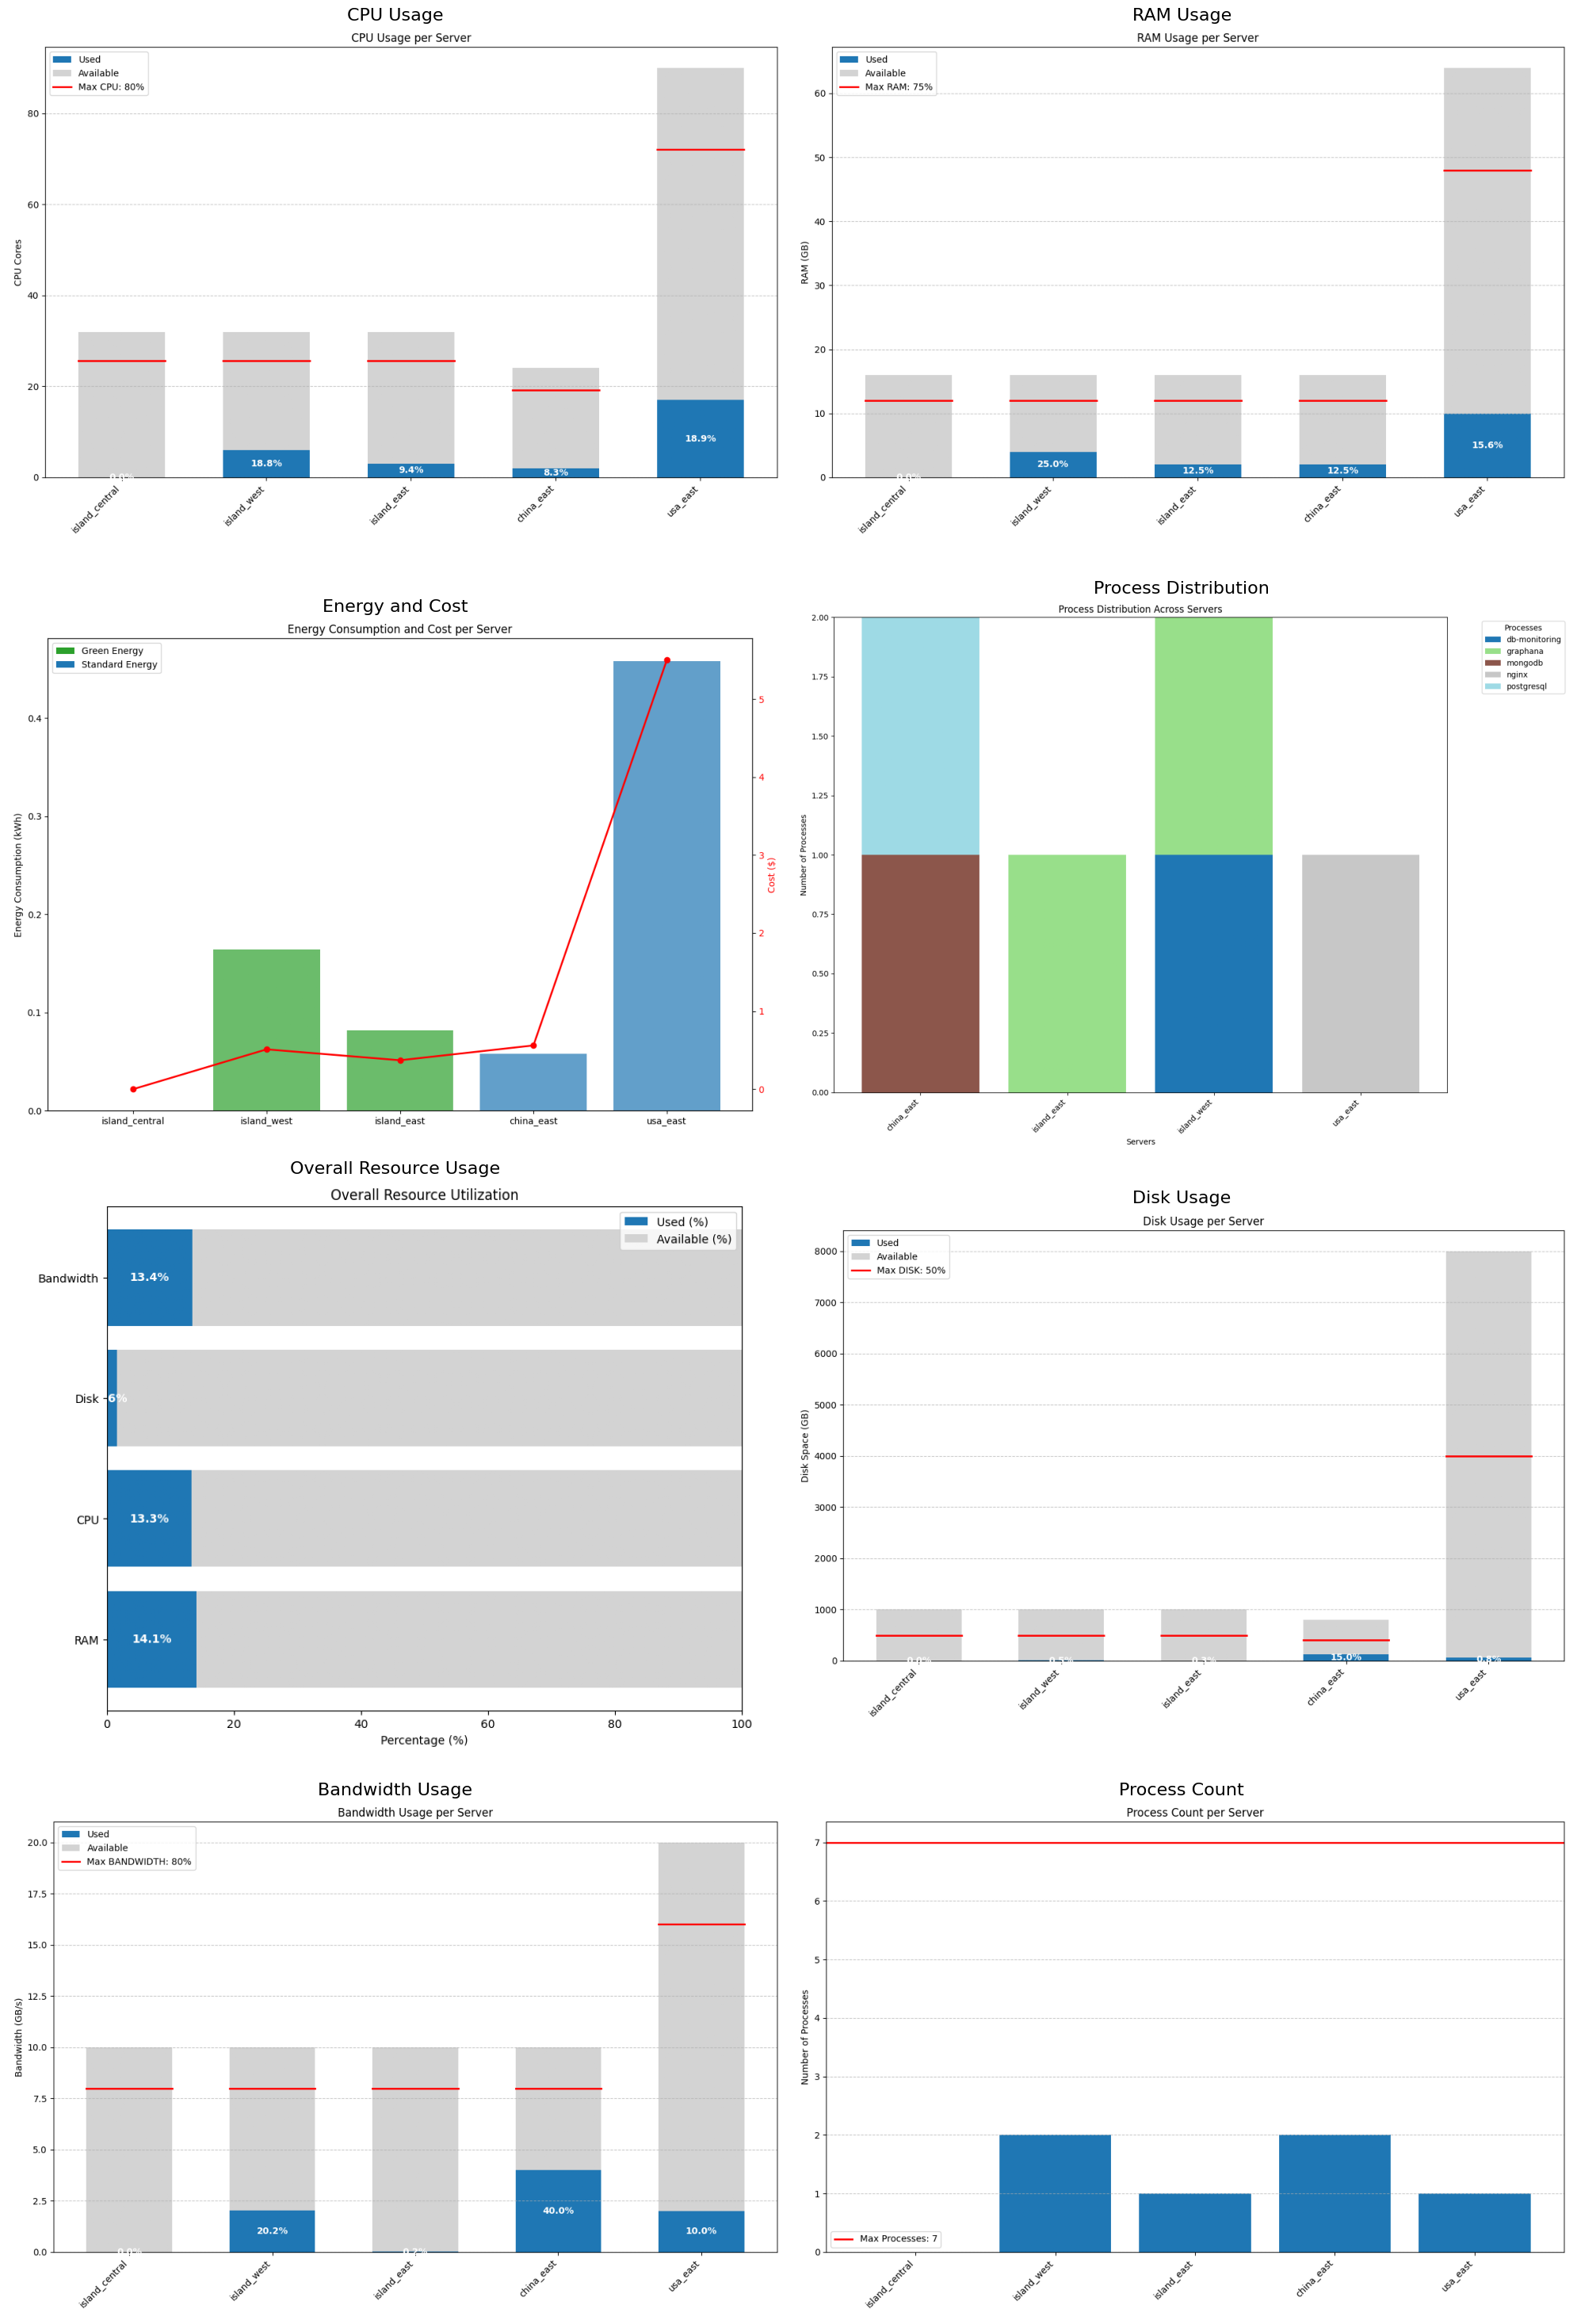

✅ All charts generated successfully!
📊 Individual charts saved to ./output
🖼️ Summary dashboard saved to ./output/dashboard_tiny-x.png


In [9]:
%matplotlib inline
save_charts(vm_scheduling_result, OUTPUT_DIR, PRESET_NAME, show_charts=True)

## Generate Process Allocation Output

Create a structured YAML representation of the process allocation. This output shows which processes (with their replica numbers) are assigned to each server.

The output file follows this format:
```yaml
servers:
  - name: server_name1
    processes:
      - name: process_name1
        replica: 1
        location: location_name
      - name: process_name2
        replica: 2
        location: location_name
```

This structured output can be used for deployment automation or further analysis.

In [10]:
save_processes_repartition(vm_scheduling_result, OUTPUT_DIR, PRESET_NAME)

🚀 Running allocation for preset: tiny-x
✅ YAML output written to ./output/processes-repartition-tiny-x.yml
📊 Allocation summary:
   - Servers used: 4
   - Total processes allocated: 6


## Summary and Conclusions

This notebook demonstrates a constraint programming approach to the VM scheduling problem. The key advantages of this approach include:

1. **Flexibility**: Easily accommodate various constraints and policies
2. **Optimality**: Find solutions that balance multiple objectives
3. **Visibility**: Generate visualizations to understand resource utilization
4. **Automation**: Output structured allocation data for deployment systems

The constraint programming model handles complex allocation scenarios that would be difficult to solve with simpler heuristics or manual approaches.

### Next Steps

- Try different presets and constraint configurations
- Evaluate the solution quality against other approaches
- Integrate with deployment systems for automated resource allocation